In [1]:
import pandas as pd
import numpy as np

#read data

crypto_prices = pd.read_csv("data/crypto_prices.csv", index_col=0, sep = ';')

In [2]:
#initialize copula objects

from pyscarcopula import GumbelCopula, FrankCopula, JoeCopula, ClaytonCopula
from pyscarcopula import VineCopula, GaussianCopula, StudentCopula

copula = GumbelCopula(dim = 2)

In [3]:
#copula cdf symbolic expression

copula.sp_cdf()

exp(-((-log(u0))**r + (-log(u1))**r)**(1/r))

In [4]:
#consider bivariate case for copula fit

tickers = ['BTC-USD', 'ETH-USD']

returns_pd = np.log(crypto_prices[tickers] / crypto_prices[tickers].shift(1))[1:501]
returns = returns_pd.values

fit_result = copula.fit(data = returns, method = 'scar-m-ou', seed = 333, to_pobs = True)
fit_result

           message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
           success: True
            status: 0
               fun: 219.33843671302438
                 x: [ 9.619e-01  2.346e+00  1.451e+00]
               nit: 6
               jac: [-2.045e-03  5.006e-03  2.361e-03]
              nfev: 28
              njev: 7
          hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
              name: Gumbel copula
            method: scar-m-ou
 latent_process_tr: 500
        stationary: False
      M_iterations: 3

In [5]:
#goodness of fit for Archimedian copula

from pyscarcopula.stattests import gof_test

gof_test(copula, returns, fit_result, to_pobs=True)

CramerVonMisesResult(statistic=0.19260862172251336, pvalue=0.28221824469771717)

In [6]:
#sampling from copula with constant parameter

copula.get_sample(size = 1000, r = 1.2)

array([[0.9868179 , 0.40826026],
       [0.97192973, 0.17828747],
       [0.06584484, 0.23687022],
       ...,
       [0.23231036, 0.32290286],
       [0.41639128, 0.72424316],
       [0.61180702, 0.38970577]])

In [7]:
#sampling from copula with time-dependent parameter

from pyscarcopula.sampler.sampler_ou import stationary_state_ou

size = 2000
random_process_state = copula.transform(stationary_state_ou(fit_result.x, size))

copula.get_sample(size = size, r = random_process_state)

array([[0.37088528, 0.07349461],
       [0.87424108, 0.92367817],
       [0.55188297, 0.47116025],
       ...,
       [0.84133634, 0.54618992],
       [0.6549479 , 0.57211257],
       [0.62748246, 0.55422307]])

In [8]:
#consider multivariate case

tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD']

returns_pd = np.log(crypto_prices[tickers] / crypto_prices[tickers].shift(1))[1:]
returns = returns_pd.values

In [9]:
copula = StudentCopula()

In [11]:
from pyscarcopula.metrics import risk_metrics

gamma = [0.95]
window_len = 250
latent_process_tr = 500
MC_iterations = [int(10**5)]
M_iterations = 5

#fastest calculations
method = 'mle'
# marginals_method = 'normal'

#More precise calculations. For appropiate choice of latent_process_tr and M_iterations see README.md
# method = 'scar-p-ou' # or use 'scar-m-ou'
marginals_method = 'johnsonsu'

count_instruments = len(tickers)
portfolio_weight = np.ones(count_instruments) / count_instruments
result = risk_metrics(copula,
                      returns,
                      window_len,
                      gamma,
                      MC_iterations,
                      marginals_method = marginals_method,
                      latent_process_type = method,
                      optimize_portfolio = False,
                      portfolio_weight = portfolio_weight,

                      latent_process_tr = latent_process_tr,
                      M_iterations = M_iterations,
                      )

calc marginals params
calc portfolio risks
gamma = 0.95, MC_iterations = 100000


100%|██████████| 1211/1211 [09:34<00:00,  2.11it/s]


In [12]:
var = result[0.95][100000]['var']
cvar = result[0.95][100000]['cvar']
portfolio_weight = result[0.95][100000]['weight']

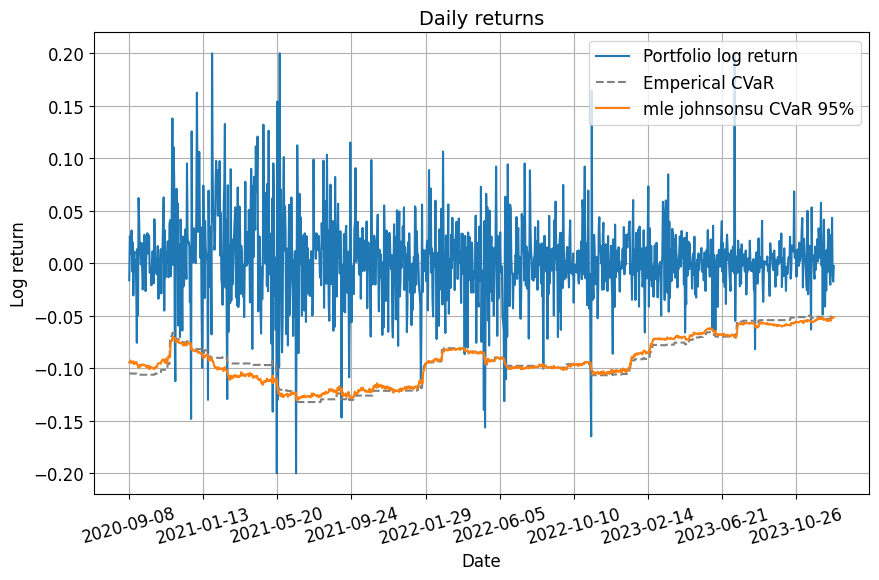

In [14]:
from pyscarcopula.metrics import cvar_emp_window
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker

pd_var_95 = pd.Series(data = -result[gamma[0]][MC_iterations[0]]['var'], index=returns_pd.index).shift(1)
pd_cvar_95 = pd.Series(data = -result[gamma[0]][MC_iterations[0]]['cvar'], index=returns_pd.index).shift(1)


weight = result[gamma[0]][MC_iterations[0]]['weight']

n = 1
m = 1
i1 = window_len
i2 = len(returns) - 1

fig,ax = plt.subplots(n,m,figsize=(10,6))
loc = plticker.MultipleLocator(base=127.0)

daily_returns = ((np.exp(returns_pd) - 1) * weight).sum(axis=1)
cvar_emp = cvar_emp_window(daily_returns.values, 1 - gamma[0], window_len)

ax.plot(np.clip(daily_returns, -0.2, 0.2)[i1:i2], label = 'Portfolio log return')
ax.plot(cvar_emp[i1:i2], label = 'Emperical CVaR', linestyle='dashed', color = 'gray')

ax.plot(pd_cvar_95[i1:i2], label= f'{method} {marginals_method} CVaR 95%')

ax.set_title(f'Daily returns', fontsize = 14)

ax.xaxis.set_major_locator(loc)
ax.set_xlabel('Date', fontsize = 12, loc = 'center')
ax.set_ylabel('Log return', fontsize = 12, loc = 'center')
ax.tick_params(axis='x', labelrotation = 15, labelsize = 12)
ax.tick_params(axis='y', labelsize = 12)
ax.grid(True)
ax.legend(fontsize=12, loc = 'upper right')